In [51]:
# risk estimation of SGD for (pseudo) Huber regression
# risk estimation of SPGD for (pseudo) Huber Lasso regression

import sys
import numpy as np
from numpy.linalg import norm
import scipy.linalg as linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_style('darkgrid')

dim_set = 1 # int(sys.argv[1])
loss_set = 1 #int(sys.argv[2])
eta_set = 2

if  dim_set == 1:
    n, p, T, lam = 3000, 1000, 20, 0 # no regularization
if  dim_set == 4:
    n, p, T, lam = 3000, 4000, 20, 0.002 # no regularization

if loss_set == 1:
    loss = 'Huber'
if loss_set == 2:
    loss = 'pseudo_Huber'

batch_size = n//5
print('loss, method, n, p, T, batch size, lam:\n', loss, 'SGD', n, p, T, batch_size, lam)

# learning rate schedule
# eta = (1 + (p/batch_size)**(0.5))**(-2) * np.ones(T) # constant schedule
# eta = np.ones(T) # constant schedule
# eta = np.tile([0,0,2], T//3) # require T is a mupltiple of 3
# eta = np.tile([1,0], T//2) # require T is a mupltiple of 2
if eta_set == 1:
    eta = np.tile([1,0], T//2) # require T is a mupltiple of 2
if eta_set == 2:
    eta = np.tile([1,0.5], T//2) # require T is a mupltiple of 2

beta = np.zeros(p)
s = int(p/20)
beta[:s] = 1
Sigma = np.eye(p)#linalg.toeplitz(0.5 ** np.arange(p))
signal = 10 
beta[:s] = beta[:s] * np.sqrt(signal / (beta[:s].T @ Sigma[:s,:s] @ beta[:s]))
print('signal strength:', signal)

def sqrt_mat_sym(M):
    # square root for symmetric matrix
    s, v = np.linalg.eigh(M)
    sq_root = v * np.sqrt(s) @ v.T
    return sq_root

Sigma_sq_root = sqrt_mat_sym(Sigma)

if loss == 'Huber':
    def psi(r, delta=1):
        out = np.where(np.abs(r) <= delta, r, delta * np.sign(r))
        # out = r
        return out
    def psi_prime(r, delta=1):
        out = np.where(np.abs(r) <= delta, 1, 0)
        # out = np.ones_like(r)
        return out

if loss == 'pseudo_Huber':
    def psi(r, delta=1):
        return r / np.sqrt(1 + (r/delta)**2)
    def psi_prime(r, delta=1):
        return (1 + (r/delta)**2)**(-3/2)

def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

# use Hutchinson's trace approximation
approx = True
if approx:
    m0 = 2
    m = 2
    np.random.seed(42)
    r0 = np.random.choice([-1, 1], size=(p, m0))/np.sqrt(m0)  # shape (p, m)
    r = np.random.choice([-1, 1], size=(n, m))/np.sqrt(m) # shape (n, m)
else: # do not approximate
    m0 = p
    m = n
    r0 = np.eye(p)
    r = np.eye(n)
r0TSigma = r0.T @ Sigma # required knowing Sigma

# selected batch for each iteration
ind = [np.random.choice(n, size=batch_size, replace=False) for _ in range(T)]
S = np.zeros((n, T))
for t in range(T):
    S_t = np.zeros(n, dtype=int)
    S_t[ind[t]] = 1
    S[:,t] = S_t


loss, method, n, p, T, batch size, lam:
 Huber SGD 3000 1000 20 600 0
signal strength: 10


In [52]:
def one_run(seed):
    # geenrate data
    np.random.seed(seed)
    X = np.random.randn(n, p) #@ Sigma_sq_root
    eps = np.random.standard_t(df=3, size=n)
    # eps = np.random.laplace(loc=0, scale=2, size=n) # Laplace distribution

    y = X @ beta + eps
    # snr = norm(beta)**2/(norm(eps)**2/n)
    # print('snr:', snr)

    # run stochastic gradient descent
    # eta = n / norm(X, ord=2)**2 
    b = np.zeros(p)
    B_hat = np.zeros((p, T))

    n_t = batch_size

    for t in range(1, T):
        eta_t = eta[t-1]
        # X_t = X[ind[t], :]
        # y_t = y[ind[t]]
        # b += eta/n * X.T @ psi(y - X @ b)        # GD
        # u = b + eta/n * X.T @ psi(y - X @ b)     # PGD
        # u = b+ eta_t/n_t * X_t.T @ psi(y_t - X_t @ b)    # SPGD
        u = b + eta_t/n_t * X.T * S[:,t-1] @ psi(y - X @ b)    # SPGD
        b = soft_threshold(u, lam*eta_t)
        B_hat[:,t] = b

    H = Sigma_sq_root @ (B_hat - beta[:, np.newaxis])
    R = y[:, np.newaxis] - X @ B_hat
    F = S * psi(R)

    D = psi_prime(R)
    D_tr = np.sum(D, 0)
    SD = S * D
    # tD = np.ones((p, T))
    tD = (B_hat[:,1:] !=0).astype(int) # shape (p, T-1)
    tD = np.hstack((tD, np.zeros((p,1)))) # shape (p, T) # last column not used, just for the shape.
    # if lam >0:
    #     assert np.any(tD!=0) # avoid too large lambda such that all beta_hat are zero
    #     assert np.any(tD!=1) # avoid too small lambda and hence obtain sparse solution

    W = np.zeros((T, T))
    tD_1 = (tD[:,0])[:, np.newaxis]
    Q_2 = eta[0]/n_t * tD_1 * r0 # shape (p, m)
    Q_t_1 = Q_2
    W[1,0] = np.trace(r0TSigma @ Q_2)

    A = np.zeros((T,T))
    K = np.zeros((T,T))
    XTr = X.T @ r
    # D1 = D[:,0]

    R_2 = eta[0]/n_t * tD_1 * XTr # shape (p, m)
    R_t_1 = R_2
    A[1,0] = np.trace(r.T * D[:,1] @ (X @ R_2))

    U_2 = eta[0]/n_t * tD_1 * X.T @ ((SD[:,0])[:, np.newaxis] * r)
    U_t_1 = U_2
    K[1,0] = np.trace(r.T * D[:,1] @ (X @ U_2))
    for t in range(2, T):
        tD_t = (tD[:,t-1])[:, np.newaxis]
        # Pt = - tD_t * (np.eye(p) - eta/n_t * X.T * SD[:,t-1] @ X)
        # PQ = tD_t * (np.eye(p) - eta/n_t * X.T * SD[:,t-1] @ X) @ Q_t_1
        PQ = tD_t * ( Q_t_1 - eta[t-1]/n_t * X.T @ ( (SD[:,t-1])[:,np.newaxis] * (X @ Q_t_1) ) )
        Q_t = np.hstack((PQ, eta[t-1]/n_t * tD_t * r0))
        W[t,:t] = np.einsum('jtj->t', (r0TSigma @ Q_t).reshape(m0, t, m0))
        Q_t_1 = Q_t

        PR = tD_t * (R_t_1 - eta[t-1]/n_t * X.T @ ( (SD[:,t-1])[:,np.newaxis] * (X @ R_t_1) ) )
        R_t = np.hstack((PR, eta[t-1]/n_t * tD_t * XTr))
        temp = r.T * D[:,t] @ (X @ R_t) 
        A[t,:t] = np.einsum('iti->t', temp.reshape(m, t, m))
        R_t_1 = R_t

        # Pt = tD_t * (np.eye(p) - eta/n_t * X.T * SD[:,t-1] @ X)
        PU = tD_t * (U_t_1 - eta[t-1]/n_t * X.T @ ( (SD[:,t-1])[:,np.newaxis] * (X @ U_t_1) ) )
        U_t = np.hstack((PU, eta[t-1]/n_t * tD_t * X.T @ ((SD[:,t-1])[:, np.newaxis] * r)))
        temp = r.T * D[:,t] @ (X @ U_t)
        # temp = r.T * (SD[:,t-1]*(D[:,t])) @ XR_t  # notice the extra SD[:,t-1]
        K[t,:t] = np.einsum('iti->t', temp.reshape(m, t, m))

        U_t_1 = U_t

    K = np.diag(D_tr) - K

    W_hat = linalg.solve_triangular(K, A, lower=True)

    risk = norm(H, axis=0)**2 # + norm(eps)**2/n
    risk_est = norm(R + F @ W.T, axis=0)**2 /n - norm(eps)**2/n
    risk_est1 = norm(R + F @ W_hat.T, axis=0)**2 /n - norm(eps)**2/n

    dict = {
        'method': 'SGD',
        'n': n,
        'p': p,
        'T': T,
        'lam': lam,
        'risk': risk,
        'risk_estimate': risk_est,
        'risk_estimate1': risk_est1,
        'iteration': np.arange(T)+1,
        'seed': seed
        }

    df = pd.DataFrame(dict)

    return df, np.hstack((W, W_hat))

# try one experiment, get the time for one repetition 
import time
start_time = time.time()
a = one_run(0)
end_time = time.time()
execution_time = end_time - start_time
print(f"one run: {execution_time} seconds")

one run: 1.6400411128997803 seconds


In [53]:
# try 100 repetitions
rep = 100
from joblib import Parallel, delayed
data_list = Parallel(n_jobs=-1, verbose=10)(
    delayed(one_run)(seedid)
    for seedid in range(rep)
    )
# data_list = []
# for seedid in tqdm(range(rep)):
#     result = one_run(seedid)
#     data_list.append(result)

#####################################################
# save completed results
risk_list, W_list = zip(*data_list)
data_risk = pd.concat(risk_list, ignore_index=True)
data_risk.to_pickle(f'SGD_data_risk_dim_{dim_set}_loss_{loss_set}.pkl' , compression='gzip')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  92 out of 100 | elapsed:   19.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.8s finished


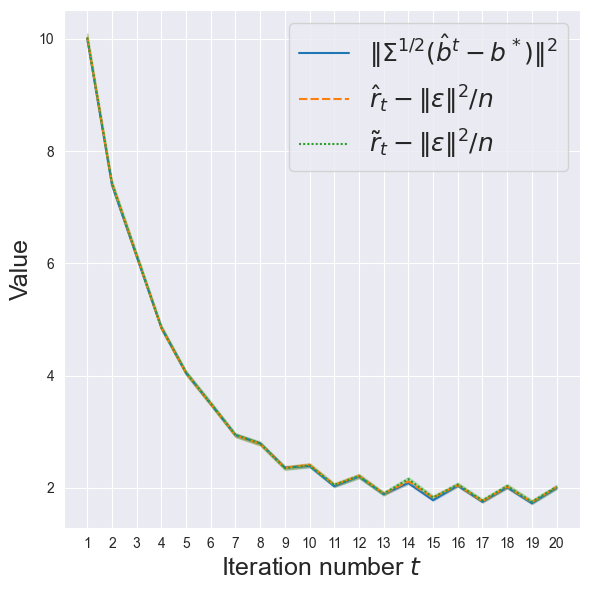

In [54]:
data_W = np.mean(np.stack(W_list, axis=0), 0) # save the mean of W and W_hat
data_W = data_W
np.save(f'SGD_data_W_dim_{dim_set}_loss_{loss_set}.npy', data_W)
#####################################################

df_risk = pd.melt(data_risk, 
                  id_vars=['iteration', 'seed'],
                  value_vars=['risk', 'risk_estimate', 'risk_estimate1'],
                  var_name='Type')

#####################################################
# virtualization 
fs = 18 # fontsize
# risk plots
plt.figure(figsize=(6, 6))  # Set the figure size as appropriate
ax = sns.lineplot(data=df_risk,
             x='iteration', y='value', hue='Type',
             style="Type", 
             style_order=['risk','risk_estimate', 'risk_estimate1'],
             errorbar=("se", 2),
             legend='auto')
# plt.xscale('log')
plt.xlabel(r'Iteration number $t$', fontsize=fs)
plt.ylabel('Value', fontsize=fs)
handles, labels = ax.get_legend_handles_labels()
new_labels = [r'$\|\Sigma^{1/2}(\hat b^t - b^*)\|^2$', r'$\hat r_t - \|\epsilon\|^2/n$', r'$\tilde r_t-\|\epsilon\|^2/n$']
# new_labels = [r'$r_t$', r'$\hat r_t$', r'$\tilde r_t$']

ax.set_xticks(np.arange(1, T+1))  # Set ticks at the middle of each matrix block
# ax.set_xticklabels([r'$\mathbf{W}$', r'$\mathbf{\widehat{W}}$'], rotation=0, fontsize=fs)


ax.legend(handles=handles, labels=new_labels, title='', fontsize=fs)
plt.tight_layout()
figname = f'SGD_eta_{eta_set}_dim_{dim_set}_loss_{loss_set}.pdf'    
plt.savefig(figname, bbox_inches='tight', dpi=300)

# # heatmap for W and W_hat 
# W_mean = data_W
# k = T # plot the first k rows and k columns
# W_sub = W_mean[:k, :k]
# W_hat_sub = W_mean[:k, T:T+k]
# W_sub_mean = np.hstack((W_sub, W_hat_sub))
# fig, ax = plt.subplots(figsize=(12, 5))
# ax = sns.heatmap(W_sub_mean, center = 0, cmap='coolwarm', 
#     xticklabels=False, yticklabels=False, cbar=True, square=True)
# ax.set_aspect('equal', 'box')  
# ax.set_xticks([0.5*k, 1.5*k])  # Set ticks at the middle of each matrix block
# ax.set_xticklabels([r'$\mathbf{W}$', r'$\mathbf{\widehat{W}}$'], rotation=0, fontsize=fs)
# plt.tight_layout()
# figname = f'SGD_W_dim_{dim_set}_loss_{loss_set}.pdf'
# plt.savefig(figname, bbox_inches='tight', dpi=300)

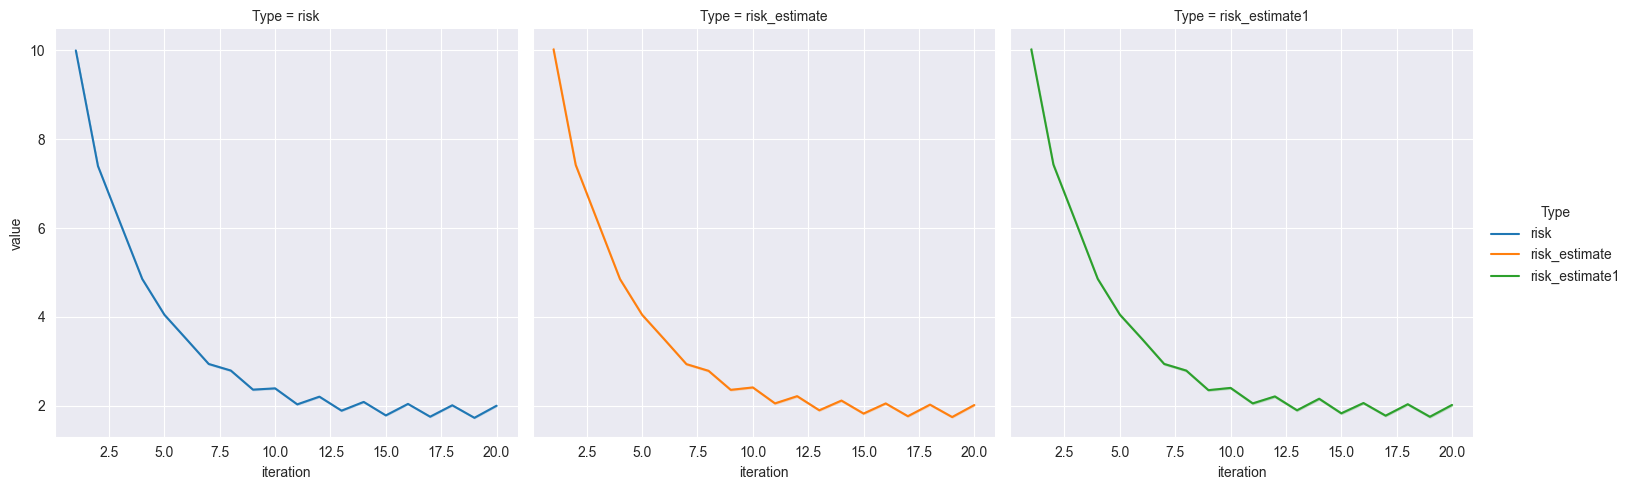

In [55]:
sns.relplot(data=df_risk,
            x='iteration', y='value', hue='Type',
            col="Type", #style_order=['risk','risk_estimate'],
            kind='line',
            errorbar=("se", 1),
            legend='auto')